Boosted Tree Classifier with TF-IDF + Date/Amount Features

In [1]:
# load processed df
from IPython.utils.capture import capture_output

with capture_output():
    %run 03_preprocessing.ipynb

Train size: 1042283  Test size: 260571
Train class counts:
label_fixed
GENERAL_MERCHANDISE    417842
FOOD_AND_BEVERAGES     384378
GROCERIES              175266
TRAVEL                  47682
PETS                     7404
EDUCATION                3589
OVERDRAFT                2709
RENT                     2518
MORTGAGE                  895
Name: count, dtype: int64 

[HGB] Train acc=0.8058  Macro-F1=0.6812
[HGB] Test  acc=0.7504  Macro-F1=0.4559
[HGB] Predict latency=4.10s  Per-sample≈0.016 ms

=== Classification report (test set) ===
                     precision    recall  f1-score   support

          EDUCATION      0.005     0.001     0.002       897
 FOOD_AND_BEVERAGES      0.725     0.759     0.742     96094
GENERAL_MERCHANDISE      0.715     0.817     0.763    104461
          GROCERIES      0.951     0.690     0.799     43817
           MORTGAGE      0.075     0.058     0.065       224
          OVERDRAFT      0.645     0.474     0.546       677
               PETS      0.431  

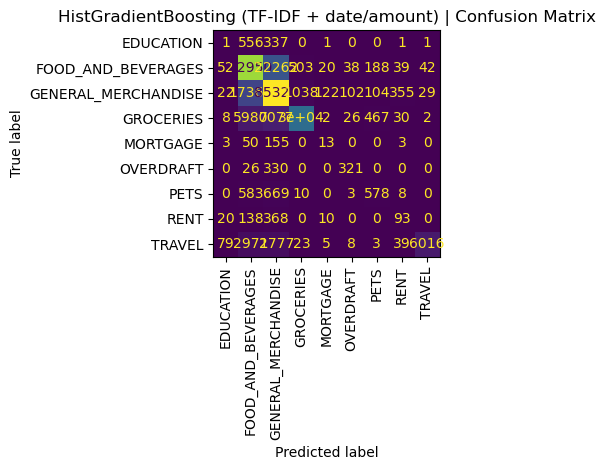

In [4]:
# ==================== CONFIG ====================
SOURCE_DF_NAME = "outflows_cleaned"   # <-- CHANGE to whatever DF 03_preprocessing creates
TEXT_COL       = "memo_clean"
LABEL_COL      = "category"
DATE_COL       = "posted_date"
AMT_COL        = "amount"
TEST_SIZE      = 0.20
RANDOM_STATE   = 42

# ==================== IMPORTS ====================
import time, numpy as np, pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import HistGradientBoostingClassifier

# ==================== LOAD DF ====================
if SOURCE_DF_NAME not in globals():
    raise NameError(
        f"DataFrame '{SOURCE_DF_NAME}' not found. "
        "Set SOURCE_DF_NAME to the DF created in 03_preprocessing."
    )

df = globals()[SOURCE_DF_NAME].copy()

# Basic coercions
df[TEXT_COL] = df[TEXT_COL].astype(str).str.strip()
df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")
df[AMT_COL]  = pd.to_numeric(df[AMT_COL], errors="coerce")
df = df.dropna(subset=[TEXT_COL, LABEL_COL, DATE_COL, AMT_COL])
df = df[df[TEXT_COL] != ""]

# ---- Handle singleton classes so stratify works ----
MIN_PER_CLASS = 2
counts = df[LABEL_COL].value_counts()
rare = counts[counts < MIN_PER_CLASS].index

df["label_fixed"] = df[LABEL_COL].astype(str)
df.loc[df["label_fixed"].isin(rare), "label_fixed"] = "OTHER"

if df["label_fixed"].value_counts().get("OTHER", 0) < MIN_PER_CLASS:
    df = df[df["label_fixed"] != "OTHER"]

X = df[[TEXT_COL, DATE_COL, AMT_COL]]
y = df["label_fixed"].astype(str)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

print("Train size:", len(X_train), " Test size:", len(X_test))
print("Train class counts:")
print(y_train.value_counts(), "\n")

from sklearn.preprocessing import FunctionTransformer

# ========== DATE / AMOUNT FEATURIZER ==========
class DateAmountFeaturizer(BaseEstimator, TransformerMixin):
    def __init__(self, date_col=DATE_COL, amt_col=AMT_COL):
        self.date_col = date_col
        self.amt_col  = amt_col

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        d   = pd.to_datetime(X[self.date_col], errors="coerce")
        amt = pd.to_numeric(X[self.amt_col], errors="coerce").abs().fillna(0.0)

        out = pd.DataFrame({
            "dow": d.dt.dayofweek.fillna(0).astype(int),
            "dom": d.dt.day.fillna(1).astype(int),
            "hour": d.dt.hour.fillna(0).astype(int),
            "amount_abs": amt,
            "is_whole_dollar": (np.isclose(amt, np.round(amt))).astype(int),
        })

        # Bin amount to capture spending “levels”
        try:
            out["amt_bin"] = pd.qcut(amt, q=10, duplicates="drop")
        except Exception:
            out["amt_bin"] = pd.cut(amt, bins=3, include_lowest=True)

        return out

num_cols = ["dow","dom","hour","amount_abs","is_whole_dollar"]
cat_cols = ["amt_bin"]

# ========== TEXT + DATE/AMOUNT FEATURES ==========
tfidf = TfidfVectorizer(
    min_df=3,
    ngram_range=(1, 2),
    analyzer="word",
    max_features=100_000
)

feature_union = ColumnTransformer(
    transformers=[
        ("tfidf", tfidf, TEXT_COL),

        # numeric date/amount features only
        ("date_num", Pipeline([
            ("mk", DateAmountFeaturizer()),
            ("sel_num", FunctionTransformer(lambda df: df[num_cols], validate=False)),
            ("sc", StandardScaler(with_mean=False)),
        ]), [DATE_COL, AMT_COL]),

        # categorical bucketed amount only
        ("date_cat", Pipeline([
            ("mk", DateAmountFeaturizer()),
            ("sel_cat", FunctionTransformer(lambda df: df[cat_cols], validate=False)),
            ("oh", OneHotEncoder(handle_unknown="ignore")),
        ]), [DATE_COL, AMT_COL]),
    ],
    verbose_feature_names_out=False,
)


# ========== NEW MODEL: Boosted Trees (HistGradientBoosting) ==========
gb_pipe = Pipeline([
    ("features", feature_union),
    ("svd", TruncatedSVD(n_components=100, random_state=RANDOM_STATE)),
    ("sc", StandardScaler()),
    ("clf", HistGradientBoostingClassifier(
        max_depth=10,
        learning_rate=0.1,
        max_iter=200,
        random_state=RANDOM_STATE
    ))
])

t0 = time.perf_counter()
gb_pipe.fit(X_train, y_train)
train_time = time.perf_counter() - t0

y_train_pred = gb_pipe.predict(X_train)
train_acc = accuracy_score(y_train, y_train_pred)
train_macro_f1 = f1_score(y_train, y_train_pred, average="macro")

t1 = time.perf_counter()
y_test_pred = gb_pipe.predict(X_test)
pred_time = time.perf_counter() - t1
test_acc = accuracy_score(y_test, y_test_pred)
test_macro_f1 = f1_score(y_test, y_test_pred, average="macro")
latency_ms = 1000 * pred_time / max(len(X_test), 1)

print(f"[HGB] Train acc={train_acc:.4f}  Macro-F1={train_macro_f1:.4f}")
print(f"[HGB] Test  acc={test_acc:.4f}  Macro-F1={test_macro_f1:.4f}")
print(f"[HGB] Predict latency={pred_time:.2f}s  Per-sample≈{latency_ms:.3f} ms\n")

print("=== Classification report (test set) ===")
print(classification_report(y_test, y_test_pred, digits=3))

ConfusionMatrixDisplay.from_predictions(
    y_test, y_test_pred, xticks_rotation=90, colorbar=False
)
plt.title("HistGradientBoosting (TF-IDF + date/amount) | Confusion Matrix")
plt.tight_layout()
plt.show()



In [5]:
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
)

def evaluate_model(y_true, y_pred, model_name="Model"):
    print(f"\n===== {model_name} – Overall Metrics =====")
    acc = accuracy_score(y_true, y_pred)
    prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(
        y_true, y_pred, average="macro", zero_division=0
    )
    prec_weighted, rec_weighted, f1_weighted, _ = precision_recall_fscore_support(
        y_true, y_pred, average="weighted", zero_division=0
    )
    
    print(f"Accuracy       : {acc:.4f}")
    print(f"Macro Precision: {prec_macro:.4f}")
    print(f"Macro Recall   : {rec_macro:.4f}")
    print(f"Macro F1       : {f1_macro:.4f}")
    print(f"Weighted F1    : {f1_weighted:.4f}")

    print(f"\n===== {model_name} – Per-Class Report =====")
    # this includes precision, recall, f1-score, support per class
    print(classification_report(y_true, y_pred, digits=3, zero_division=0))


In [6]:
evaluate_model(y_test, y_test_pred, model_name="HistGradientBoosting (TF-IDF + date/amount)")



===== HistGradientBoosting (TF-IDF + date/amount) – Overall Metrics =====
Accuracy       : 0.7504
Macro Precision: 0.5221
Macro Recall   : 0.4182
Macro F1       : 0.4559
Weighted F1    : 0.7487

===== HistGradientBoosting (TF-IDF + date/amount) – Per-Class Report =====
                     precision    recall  f1-score   support

          EDUCATION      0.005     0.001     0.002       897
 FOOD_AND_BEVERAGES      0.725     0.759     0.742     96094
GENERAL_MERCHANDISE      0.715     0.817     0.763    104461
          GROCERIES      0.951     0.690     0.799     43817
           MORTGAGE      0.075     0.058     0.065       224
          OVERDRAFT      0.645     0.474     0.546       677
               PETS      0.431     0.312     0.362      1851
               RENT      0.164     0.148     0.155       629
             TRAVEL      0.988     0.505     0.668     11921

           accuracy                          0.750    260571
          macro avg      0.522     0.418     0.456    26

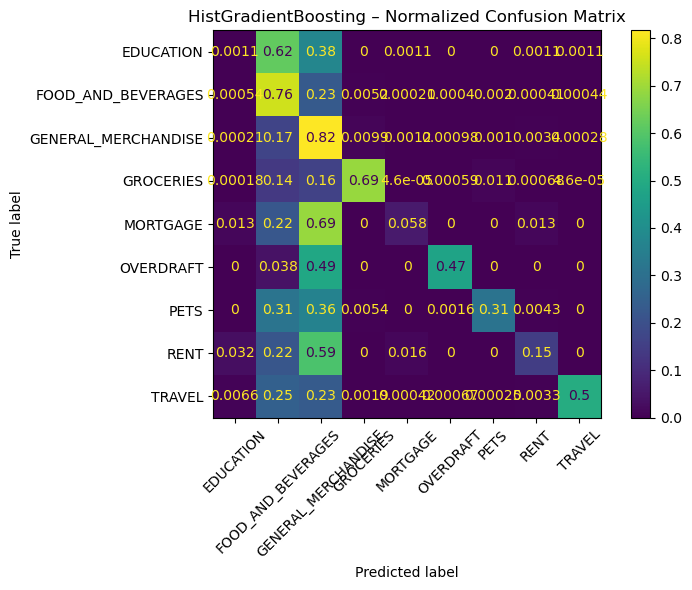

In [8]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_test_pred,
    normalize="true",          # each row sums to 1 → percentage per class
    xticks_rotation=45,
    colorbar=True,
    ax=ax
)

ax.set_title("HistGradientBoosting – Normalized Confusion Matrix")
plt.tight_layout()
plt.show()


,label,precision,recall,f1,support
0,EDUCATION,0.005405,0.001115,0.001848,897
1,FOOD_AND_BEVERAGES,0.725005,0.759152,0.741686,96094
2,GENERAL_MERCHANDISE,0.715209,0.816793,0.762633,104461
3,GROCERIES,0.950502,0.689801,0.799434,43817
4,MORTGAGE,0.075145,0.058036,0.065491,224
5,OVERDRAFT,0.644578,0.474151,0.546383,677
6,PETS,0.431343,0.312264,0.362269,1851
7,RENT,0.163732,0.147854,0.155388,629
8,TRAVEL,0.987849,0.504656,0.668036,11921


/tmp/ipykernel_317/481190818.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(metrics_df["label"], rotation=45, ha="right")


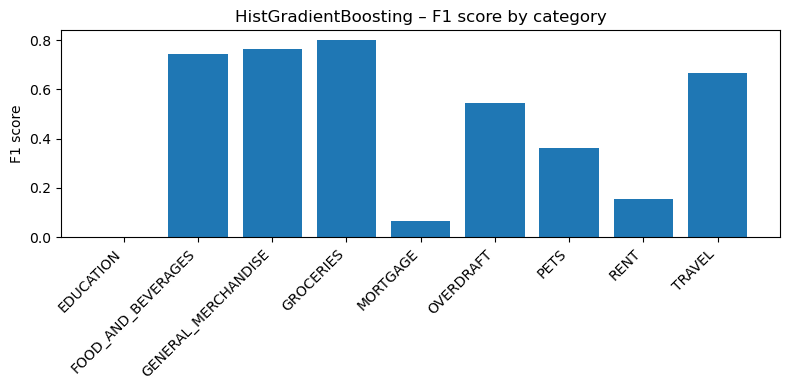

In [9]:
from sklearn.metrics import precision_recall_fscore_support
import pandas as pd
import matplotlib.pyplot as plt

# get per-class metrics
prec, rec, f1, support = precision_recall_fscore_support(
    y_test, y_test_pred, labels=sorted(y_test.unique()), zero_division=0
)

metrics_df = pd.DataFrame({
    "label": sorted(y_test.unique()),
    "precision": prec,
    "recall": rec,
    "f1": f1,
    "support": support
})

display(metrics_df)

# bar plot of F1 by class
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(metrics_df["label"], metrics_df["f1"])
ax.set_ylabel("F1 score")
ax.set_title("HistGradientBoosting – F1 score by category")
ax.set_xticklabels(metrics_df["label"], rotation=45, ha="right")
plt.tight_layout()
plt.show()
